# Chile's Significant Earthquake Events

In this project, we __import, clean and do statistical analysis__ of Chile's earthquake data from [Centro Sismológico Nacional](https://www.csn.uchile.cl) (CSN). There are two main datasets: _Chile's major earthquakes_ (magnitude Ms greater or equal to 7) and _Chile's significant earthquake_ events (with magnitude Ms greater or equal to 3). Here we analyze the second dataset of significant earthquakes, which includes events from the year 2012 till today. The first dataset is analyzed in `chile-major-earthquakes.ipynb`.

## Methods

This project is done in 2 steps:

1. Importing and Cleaning data  
2. Exploratory Data Analysis 

We scrape HTML data from the CSN website using the library `BeautifulSoup4` and use `matplotlib` and `seaborn` for graphics. The HTML tables are contained in several webpages, which we scrape and merge into one big table.

We also apply exploratory data analysis to the __Distribution of Significant Earthquakes in Space__.

## 1.  Importing and Cleaning Data

First use the packages `requests` and `bs4` to import the webpage with earthquake data. As we gonna see below, the table of this page continues in multiple pages. We need to extract the number of pages to make a full extraction of all available events.

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

sns.set()


# URL to be imported
url = 'http://evtdb.csn.uchile.cl'
# Open a URL request 
r = requests.get(url)
# Get HTML text
html_doc = r.text
# Create a BeautifulSoup object to extract HTML data using Tags
soup = BeautifulSoup(html_doc)

Those are the BS4 elements of the HTML page:

In [2]:
[type(item) for item in list(soup.children)]

[bs4.element.Doctype, bs4.element.Tag]

Let us check the total number of pages.

In [3]:
numbers = []
for item in soup.find_all('li'):
    if str(item.string).find('Página') != -1:
        for word in str(item.string).split():
            if word.isdigit():
                numbers.append(int(word))
                
print(numbers[-1])

138


This method works, but there is a more direct way, in which we do not even need to extract the page number! We just need to keep loading pages until we get an error and iteratively build up our big table.

In [12]:
%%time

df = pd.DataFrame()
page = 1
while requests.get(url+"/?page="+str(page)).status_code == 200:
    r = requests.get(url+"/?page="+str(page))
    soup = BeautifulSoup(r.text)
    df = df.append(pd.read_html(str(soup.find_all(class_="paleblue sortable")))[0], ignore_index=True)
    page += 1
else:
    print("Failed in page " + str(page) + " due to HTTP code " + str(requests.get(url+"/?page="+str(page)).status_code))

Failed in page 139 due to HTTP code 500
CPU times: user 8.52 s, sys: 404 ms, total: 8.92 s
Wall time: 38.2 s


Let us check our imported table, displaying earthquakes from 2012 till 2022.

In [36]:
df.head()

,date_utc,latitude_deg,longitude_deg,depth_km,magnitude
0,2022-01-28 00:31:27,-19.20,-69.76,115,5.4
1,2022-01-25 13:40:20,-19.64,-69.21,103,4.9
2,2021-12-30 16:37:35,-19.61,-69.20,105,4.8
3,2021-12-19 21:35:39,-22.04,-70.33,54,4.5
4,2021-12-14 04:23:57,-28.61,-71.28,37,5.3


In [37]:
df.tail()

,date_utc,latitude_deg,longitude_deg,depth_km,magnitude
2746,2012-03-24 07:28:33,-33.05,-71.06,69,5.2
2747,2012-03-19 21:52:39,-25.00,-69.75,100,5.0
2748,2012-03-10 02:26:57,-19.74,-69.25,101,5.3
2749,2012-03-04 16:27:20,-21.60,-70.06,47,5.3
2750,2012-03-03 11:01:47,-30.19,-71.45,35,5.6


Let us convert the colums to English.

In [38]:
cols = ['date_utc', 'latitude_deg', 'longitude_deg', 'depth_km', 'magnitude'] 
df.columns = cols
df.head()

,date_utc,latitude_deg,longitude_deg,depth_km,magnitude
0,2022-01-28 00:31:27,-19.20,-69.76,115,5.4
1,2022-01-25 13:40:20,-19.64,-69.21,103,4.9
2,2021-12-30 16:37:35,-19.61,-69.20,105,4.8
3,2021-12-19 21:35:39,-22.04,-70.33,54,4.5
4,2021-12-14 04:23:57,-28.61,-71.28,37,5.3


The data is nicely formatted and there are no null values.

In [39]:
df.isna().sum()

date_utc         0
latitude_deg     0
longitude_deg    0
depth_km         0
magnitude        0
dtype: int64

We can even easily convert the date to `datetime` format.

In [40]:
df['date_utc'] = df['date_utc'].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2726 entries, 0 to 2750
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date_utc       2726 non-null   datetime64[ns]
 1   latitude_deg   2726 non-null   float64       
 2   longitude_deg  2726 non-null   float64       
 3   depth_km       2726 non-null   int64         
 4   magnitude      2726 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 127.8 KB


However, there are some duplicate rows.

In [41]:
df[df.duplicated(keep=False)].head()

,date_utc,latitude_deg,longitude_deg,depth_km,magnitude


Because they are exactly equal, we can simply drop duplicates.

In [44]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2726 entries, 0 to 2750
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date_utc       2726 non-null   datetime64[ns]
 1   latitude_deg   2726 non-null   float64       
 2   longitude_deg  2726 non-null   float64       
 3   depth_km       2726 non-null   int64         
 4   magnitude      2726 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 127.8 KB


## 2. Spatial Distribution of Significant Earthquakes

Our table contains sismic events ordered by datetime, location, depth and magnitude. The questions we want to address in this notebook are

* How are the events distributed in space?
* How do the events distribute with respect to their depth in km?

To better assess the spatial distribution of earthquakes, let us take a table with the latitude and longitudes of Chilean cities.

In [342]:
cities = pd.read_csv('chile_cities.csv')
cop = [cities[cities.city == 'Copiapó'].lng.iloc[0], cities[cities.city == 'Copiapó'].lat.iloc[0]]
coq = [cities[cities.city == 'Coquimbo'].lng.iloc[0], cities[cities.city == 'Coquimbo'].lat.iloc[0]]
iqu = [cities[cities.city == 'Iquique'].lng.iloc[0], cities[cities.city == 'Iquique'].lat.iloc[0]]
sant = [cities[cities.city == 'Santiago'].lng.iloc[0], cities[cities.city == 'Santiago'].lat.iloc[0]]
val = [cities[cities.city == 'Valdivia'].lng.iloc[0], cities[cities.city == 'Valdivia'].lat.iloc[0]]
cities_locations = [cop, coq, iqu, sant, val]

We call for a summary statistics to understand our data.

In [338]:
df.describe()

,latitude_deg,longitude_deg,depth_km,magnitude
count,2726.000000,2726.000000,2726.000000,2726.000000
mean,-27.598474,-70.845106,60.403155,4.550037
std,5.964103,1.298555,38.863931,0.658420
min,-62.350000,-74.820000,2.000000,2.300000
25%,-31.670000,-71.610000,35.000000,4.100000
50%,-29.655000,-71.170000,48.000000,4.500000
75%,-21.112500,-70.070000,84.000000,4.900000
max,-11.070000,-58.390000,624.000000,8.400000


In [339]:
cities[(cities.lat.astype(int) == int(df.latitude_deg.mean())) & (cities.lng.astype(int) == int(df.longitude_deg.mean()))]

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
21,Copiapó,-27.3665,-70.3323,Chile,CL,Atacama,admin,150804.0,150804.0


The mean latitude and logitude of earthquakes is (-27.59, -70.84), approximately the location of Copiapó, Atacama. The longitude has a small standard deviation, as expected from Chilean territory. The longitude has standard deviation approximately equal to 6, which does not take us too far south. If the distribution of earthquakes would be normal, that would suggest that most earthquakes happen in the Northern part of Chile. We can check this by a simple plot of the distribution of events in latitude and longitude. 

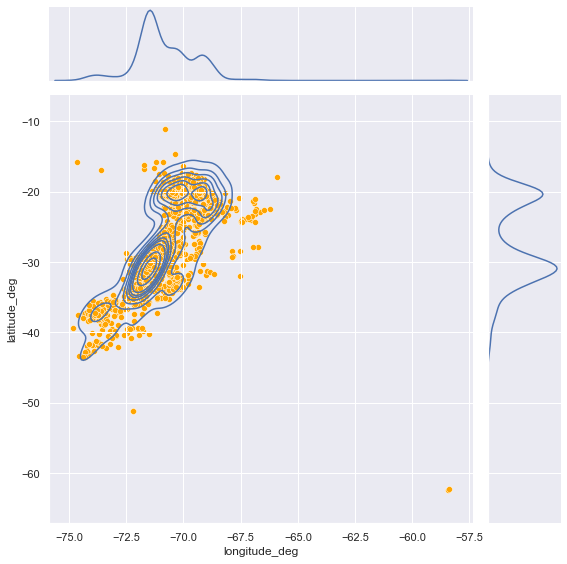

In [341]:
g = sns.jointplot(x = 'longitude_deg', y ='latitude_deg', data=df, kind='kde', height=8)
_ = g.plot_joint(sns.scatterplot, color="orange", zorder=0)

Some of the earthquakes happened in Antartica, next to King George Island, far away from Chile mainland. We will discard this outlier to make better plots.

In [236]:
df[(df.longitude_deg > -65)]

,date_utc,latitude_deg,longitude_deg,depth_km,magnitude
105,2021-04-18 02:15:13,-62.35,-58.45,11,5.0
113,2021-04-10 07:14:01,-62.30,-58.39,5,5.1


In [343]:
df_main = df[df.longitude_deg < -65.0]

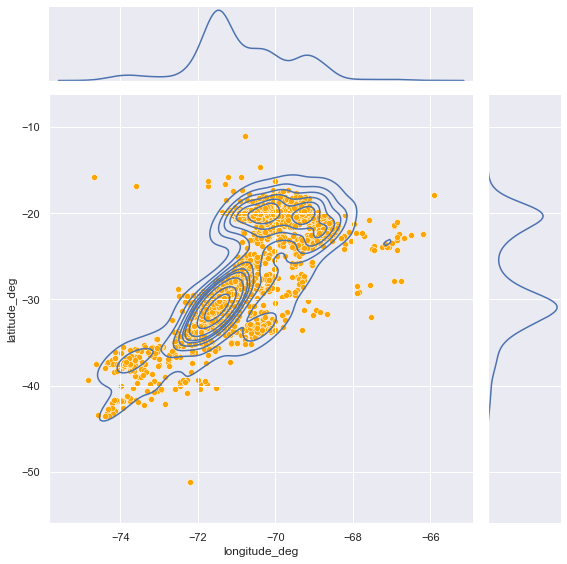

In [363]:
g = sns.jointplot(x = 'longitude_deg', y ='latitude_deg', data=df_main, kind='kde', height=8, ax=ax)
_ = g.plot_joint(sns.scatterplot, color="orange", zorder=0)

Much better now. The latitude distribution actually has two peaks around latitudes 20.2 and 30.8 degrees south. These are the latitudes of Iquique and Coquimbo, respectively, which confirms our suspicion that most earthquakes happens in Northern Chile.  

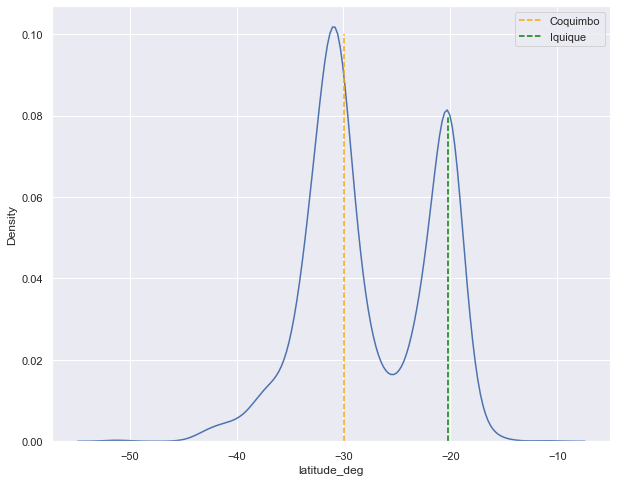

In [364]:
ax = sns.kdeplot(x='latitude_deg', data=df_main)
line1 = ax.vlines(coq[1], ymin=0, ymax=0.1, color='orange', label='Coquimbo', linestyle='dashed')
line2 = ax.vlines(iqu[1], ymin=0, ymax=0.08, color='green', label='Iquique', linestyle='dashed')
_ = ax.legend()

Now let us plot the distribution of the earthquakes depths in km in with different colors and sizes. 

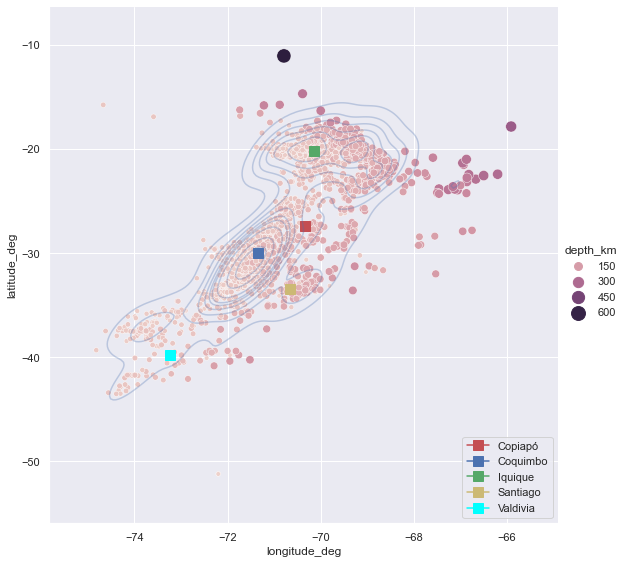

In [390]:
_ = sns.relplot(x='longitude_deg', y='latitude_deg',\
                hue='depth_km', size='depth_km', sizes=(20,200), data=df_main, height=8)

#fig, ax = plt.subplots()
colors = ['r', 'b', 'g', 'y', 'cyan']
names = ['Copiapó', 'Coquimbo', 'Iquique', 'Santiago', 'Valdivia']
dot = []
for i, city in enumerate(cities_locations):
    p, = plt.plot(city[0], city[1], marker='s', markersize=10, color=colors[i], label=names[i])
    dot.append(p)
    
_ = plt.legend(handles = dot, loc='lower right')
# _= plt.plot(coq[0], coq[1], 'bs')
# _= plt.plot(iqu[0], iqu[1], 'bs')
_ = sns.kdeplot(x = df_main.longitude_deg, y = df_main.latitude_deg, alpha=.3)

This makes evident that most earthquakes are relatively shallow (lighter circles) and located in the mainland. Deeper earthquakes (darker circles) seem to be distributed along the Andes and also to the North of Chile.

## Next Steps

* Do a more detailed statistical analysis on the distribution of earthquakes.
* Check the Gutenber-Ritcher (Log(number of events per century) vs. magnitude) and Utsu-Omori laws (distribution of replicas with time).
* Can we find correlations between these events and other geophysical data like volcano eruptions?
* Explore other datasets with a larger quantity of events.
* Try to predict earthquakes from seismograph data.